In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [3]:
samples = pd.read_csv('../sample_sheet.csv')
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location
0,W1_C1,W1,C1,S1_L23,2019 12 09,177.265396,180,W1/C1
1,W1_C2,W1,C2,S1_L23,2019 12 09,265.898093,270,W1/C2
2,W1_C8,W1,C8,S1_L23,2019 12 10,315.138481,320,W1/C8
3,W2_C3,W2,C3,S1_L23,2019 12 12,236.353861,240,W2/C3
4,W2_C4,W2,C4,S1_L23,2019 12 12,285.594248,290,W2/C4
5,W2_C5,W2,C5,S1_L23,2019 12 12,408.695218,415,W2/C5
6,W2_C6,W2,C6,S1_L23,2019 12 12,196.961551,200,W2/C6
7,W3_C10,W3,C10,S1_L23,2019 12 18,364.378869,370,W3/C10
8,W3_C11,W3,C11,S1_L23,2019 12 18,226.505783,230,W3/C11
9,W4_C10,W4,C10,S1_L23,2019 12 18,206.809628,210,W4/C10


In [14]:
sample = samples.iloc[32]

In [27]:
def find_ap(signal, ap_threshold = -10):
    over_threshold = np.where(signal > ap_threshold)[0]

    if len(over_threshold) == 0:
        return []

    idx_diff = np.where(np.diff(over_threshold) != 1)[0]
    ap_count = np.append(over_threshold[0], over_threshold[idx_diff + 1])

    return ap_count

In [28]:
animal_id = sample['AnimalID']
cell_name = sample['CellName']

filename = f'../output/spontaneous-movement/{animal_id}/{cell_name}/vm/filter.pkl'
sample_data = pd.read_pickle(filename)

In [108]:
time = sample_data.times
action_potentials = []

for channel in sample_data.ch_names:
    signal = sample_data.get_data(picks = [channel])[0]
    differential = np.diff(signal)
    aps = find_ap(signal, ap_threshold = -20)
    
    for ap_index in aps:
        exact_onset = np.where(differential[(ap_index - 25):(ap_index + 50)] > 1)[0][0] + ap_index - 25

        action_potentials.append(pd.DataFrame({
            'Channel': [channel],
            'Time': time[exact_onset],
            'Voltage': signal[exact_onset],
            'SID': sample['SID'],
            'Region': sample['Region']
        }))

action_potentials = pd.concat(action_potentials)

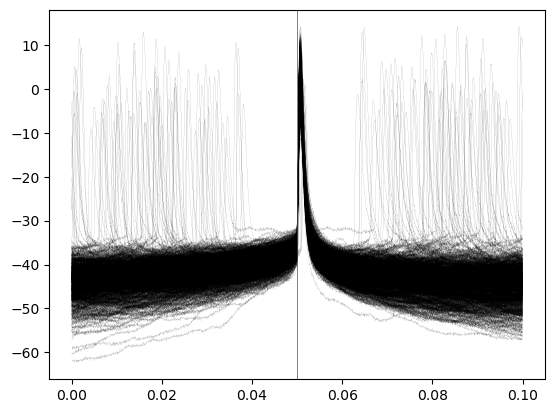

In [112]:
for index, ap in action_potentials.iterrows():
    channel = ap['Channel']
    start = ap['Time'] - 0.05
    end = ap['Time'] + 0.05
    
    if start < 0: continue
    if end > np.max(sample_data.times): continue
    
    signal = sample_data.copy().crop(tmin = start, tmax = end)
    x = signal.times
    y = signal.get_data(picks = [channel])[0]
    
    plt.plot(x, y, linewidth = 0.05, color = 'black')

plt.axvline(0.05, linewidth = 0.5, color = 'red')
plt.show()

# Extract action potential onset time and voltage from all samples

In [113]:
def find_ap(signal, ap_threshold = -10):
    over_threshold = np.where(signal > ap_threshold)[0]

    if len(over_threshold) == 0:
        return []

    idx_diff = np.where(np.diff(over_threshold) != 1)[0]
    ap_count = np.append(over_threshold[0], over_threshold[idx_diff + 1])

    return ap_count

In [141]:
def extract_action_potentials(sample_data, ap_threshold = -20):
    time = sample_data.times
    action_potentials = []
    
    for channel in sample_data.ch_names:
        signal = sample_data.get_data(picks = [channel])[0]
        differential = np.diff(signal)
        aps = find_ap(signal, ap_threshold = ap_threshold)
    
        if len(aps) == 0: continue
    
        for ap_index in aps:
            diff_over_th = np.where(differential[(ap_index - 25):(ap_index + 25)] > 1)[0]
            if len(diff_over_th) == 0: continue
            exact_onset = diff_over_th[0] + ap_index - 25
    
            action_potentials.append(pd.DataFrame({
                'Channel': [channel],
                'Time': time[exact_onset],
                'Voltage': signal[exact_onset]
            }))
    
    if len(action_potentials) > 0:
        action_potentials = pd.concat(action_potentials)
    
    return action_potentials

In [142]:
aps = []
for index, sample in samples.iterrows():
    print(f'Processing {sample["SID"]}')
    animal_id = sample['AnimalID']
    cell_name = sample['CellName']
    
    filename = f'../output/spontaneous-movement/{animal_id}/{cell_name}/vm/filter.pkl'
    sample_data = pd.read_pickle(filename)
    
    sample_aps = extract_action_potentials(sample_data)
    
    if len(sample_aps) == 0: continue
    
    sample_aps['SID'] = sample['SID']
    sample_aps['Region'] = sample['Region']
    sample_aps['AnimalID'] = sample['AnimalID']
    sample_aps['CellName'] = sample['CellName']
    
    aps.append(sample_aps)

aps = pd.concat(aps)

Processing W1_C1
Processing W1_C2
Processing W1_C8
Processing W2_C3
Processing W2_C4
Processing W2_C5
Processing W2_C6
Processing W3_C10
Processing W3_C11
Processing W4_C10
Processing W3_C12
Processing W3_C13
Processing W3_C14
Processing W3_C15
Processing W3_C16
Processing W4_C11
Processing W4_C12
Processing W4_C13
Processing W4_C14
Processing W4_C15
Processing W1_C3
Processing W1_C4
Processing W1_C5
Processing W1_C6
Processing W2_C1
Processing W2_C2
Processing W3_C1
Processing W3_C2
Processing W3_C3
Processing W3_C7
Processing W4_C1
Processing W4_C2
Processing W2_C7
Processing W3_C4
Processing W3_C5
Processing W3_C6
Processing W3_C8
Processing W4_C3
Processing W4_C4
Processing W4_C5
Processing W4_C7
Processing W4_C8


In [168]:
selected = aps[ aps['Region'] == 'S1_L5' ]

In [169]:
selected

,Channel,Time,Voltage,SID,Region,AnimalID,CellName
0,2019_12_18t9V1_6,1.18820,-35.762249,W3_C12,S1_L5,W3,C12
0,2019_12_18t9V1_6,4.64640,-33.978752,W3_C12,S1_L5,W3,C12
0,2019_12_18t9V1_7,0.81105,-35.147251,W3_C12,S1_L5,W3,C12
0,2019_12_18t9V1_7,0.83950,-33.486752,W3_C12,S1_L5,W3,C12
0,2019_12_18t9V1_7,0.93740,-37.084499,W3_C12,S1_L5,W3,C12
...,...,...,...,...,...,...,...
0,2019_12_18t42V1_29,9.65280,-20.479500,W4_C15,S1_L5,W4,C15
0,2019_12_18t42V1_29,9.89315,-23.431499,W4_C15,S1_L5,W4,C15
0,2019_12_18t42V1_29,9.90665,-24.415501,W4_C15,S1_L5,W4,C15
0,2019_12_18t42V1_29,9.92600,-22.847250,W4_C15,S1_L5,W4,C15


W3_C12
W3_C13
W3_C14
W3_C15
W3_C16
W4_C11
W4_C12
W4_C13
W4_C14
W4_C15


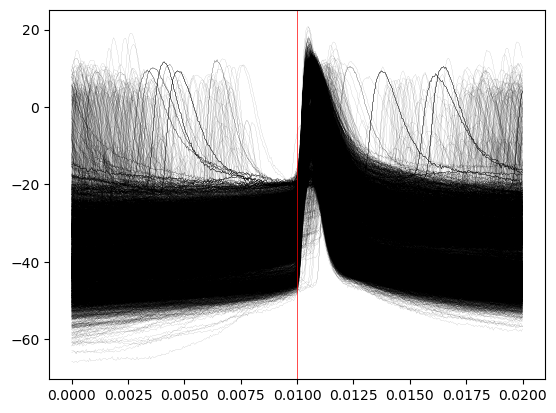

In [170]:
for sid in np.unique(selected['SID']):
    print(sid)
    action_potentials = aps[aps['SID'] == sid]

    animal_id = action_potentials['AnimalID'].iloc[0]
    cell_name = action_potentials['CellName'].iloc[0]

    filename = f'../output/spontaneous-movement/{animal_id}/{cell_name}/vm/filter.pkl'
    sample_data = pd.read_pickle(filename)

    for index, ap in action_potentials.iterrows():
        channel = ap['Channel']
        start = ap['Time'] - 0.01
        end = ap['Time'] + 0.01
    
        if start < 0: continue
        if end > np.max(sample_data.times): continue
    
        signal = sample_data.copy().crop(tmin = start, tmax = end)
        x = signal.times
        y = signal.get_data(picks = [channel])[0]
    
        plt.plot(x, y, linewidth = 0.05, color = 'black')


plt.axvline(0.01, linewidth = 0.5, color = 'red')
plt.show()

Ok, clearly the method is not perfect as there is some timing issues of some action potentials. Ignoring this worrying fact for now.

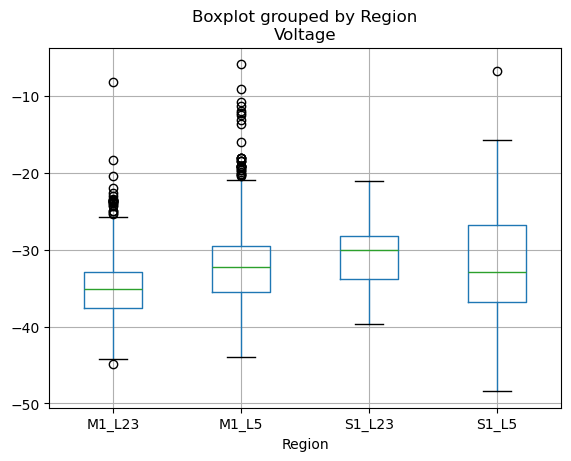

In [171]:
aps.boxplot(column = 'Voltage', by = 'Region')
plt.show()

In [172]:
regions = np.unique(aps['Region'])

for i in range(len(regions) - 1):
    for j in range(i + 1, len(regions)):
        dt1 = aps[aps['Region'] == regions[i]]['Voltage']
        dt2 = aps[aps['Region'] == regions[j]]['Voltage']
        t_statistic, p_value = ttest_ind(dt1, dt2)
        print(f'{regions[i]} vs {regions[j]}')
        print('T-statistic:', t_statistic)
        print('P-value:', p_value)
        print()

M1_L23 vs M1_L5
T-statistic: -21.02036036119012
P-value: 6.226866887189074e-95

M1_L23 vs S1_L23
T-statistic: -7.99271406341546
P-value: 2.8974108959940812e-15

M1_L23 vs S1_L5
T-statistic: -13.696807273115661
P-value: 3.152603099820518e-42

M1_L5 vs S1_L23
T-statistic: -3.042495915166626
P-value: 0.0023578500294941

M1_L5 vs S1_L5
T-statistic: -1.5218776279432902
P-value: 0.1280661079658508

S1_L23 vs S1_L5
T-statistic: 1.564662799949899
P-value: 0.11770817479597857
